In [15]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import anndata as ad
import datetime
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh

import sys
sys.path.append('/home/users/kzlin/kzlinlab/projects/veloUncertainty/git/veloUncertainty/veloUncertainty')
from countsplit import *

In [3]:
sct_seed = 615

def print_message_with_time(message):
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"{message} at {current_time}")

adata = sc.read_h5ad("/home/users/kzlin/kzlinlab/data/larry_hematopoiesis_pyro-velocity/larry.h5ad")

random.seed(sct_seed)
np.random.seed(sct_seed)

################

# Check if the layers exist before trying to delete them
layers_to_remove = ['ambiguous', 'matrix']

for layer in layers_to_remove:
    if layer in adata.layers:
        del adata.layers[layer]

# Verify the layers have been removed
print(adata.layers)

Layers with keys: spliced, unspliced


In [5]:

adata.X = adata.X.astype(np.float32)
sc.pp.calculate_qc_metrics(adata, 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)
sc.pp.highly_variable_genes(adata, 
                            flavor='seurat_v3', 
                            n_top_genes=2000, 
                            subset=True)

In [16]:
# Step 1: Log-transform the data
sc.pp.log1p(adata)  # This will log-transform adata.X in place

# Step 2: Compute the correlation matrix among all 2000 genes
# Convert to dense if adata.X is still in sparse format
data_dense = adata.X.toarray() 

# Check for NaN or infinite values and replace them with zeros or appropriate values
data_dense = np.nan_to_num(data_dense)

In [17]:
# Step 3: Compute the correlation matrix among all 2000 genes
correlation_matrix = np.corrcoef(data_dense.T)

In [18]:
# Step 4: Compute the eigendecomposition
# Compute the top 30 eigenvalues and corresponding eigenvectors
# Note: If there are fewer than 30 dimensions, adjust accordingly
k = min(30, correlation_matrix.shape[0])
eigenvalues, eigenvectors = eigsh(correlation_matrix, k=k, which='LM')


In [21]:
eigenvalues

array([ 2.30896091,  2.35984146,  2.45768778,  2.50849052,  2.57362804,
        2.65766383,  2.77555509,  2.90853948,  3.03298582,  3.18835804,
        3.25579542,  3.37426384,  3.81190771,  3.97347373,  4.38740874,
        5.00258132,  5.27241873,  5.35981862,  5.83898474,  6.74982198,
        7.85088246,  9.08960594, 10.86687855, 12.48801919, 14.26036047,
       32.05925837, 34.79897719, 46.96715564, 61.31100339, 87.52481668])

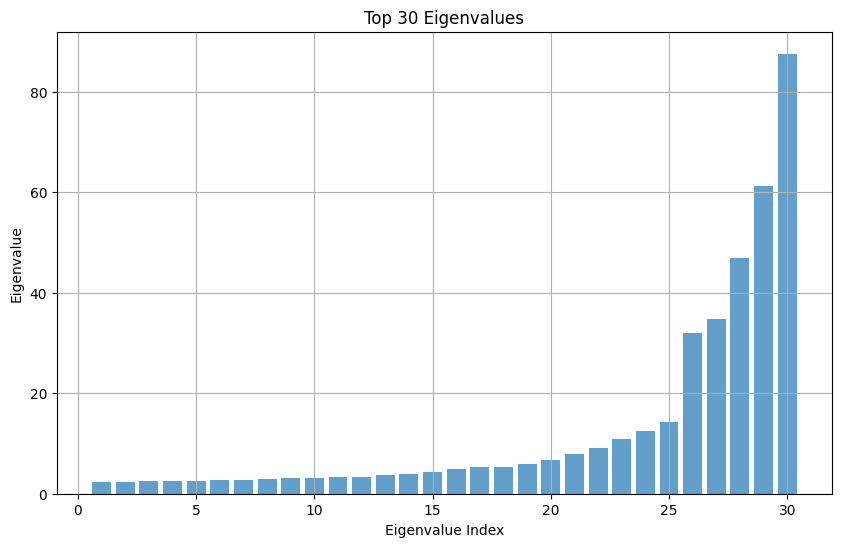

In [20]:
# Plot the eigenvalues as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, align='center')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Top 30 Eigenvalues')
plt.grid(True)
plt.show()

In [29]:
# Use the eigenvectors corresponding to the top 5 eigenvalues
# Eigenvectors' columns correspond to the variables
top_eigenvectors = eigenvectors[:, :5]

# Perform K-means clustering to cluster the variables into 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(top_eigenvectors)

# Get the cluster labels for each variable
cluster_labels = kmeans.labels_
adata.var['gene_cluster'] = cluster_labels
adata.var['gene_cluster'].value_counts()

gene_cluster
3    1023
0     497
4     274
1     187
2      19
Name: count, dtype: int64

In [30]:
# Get the indices that would sort the variables by cluster labels
sorted_indices = np.argsort(cluster_labels)

# Reorder the correlation matrix
reordered_correlation_matrix = correlation_matrix[sorted_indices, :][:, sorted_indices]

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the reordered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Reordered Correlation Matrix Based on 5 Clusters')
plt.show()


KeyboardInterrupt: 